# This notebook is the SAME as #9 but we're going to test it on noisy 2-D images with no diffim sources and investigate the noise in the resulting (corrected) diffim.

The result is in cell #20 (3rd column is std):

```
Corrected: -0.00365660933359 0.0296140052711
Original:  -0.00267542502857 0.0209849684178
Expected:  0.0               0.0282842712475
```

We're going to investigate the RHL's reinterpretation of the ZOGY (2016) algorithm which is described in RHL's slides as a post-convolution (in Fourier space) of the diffim:

$$
D(k) = [I_1(k) - \kappa(k) I_2(k)] \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}},
$$

where $I_1$ and $I_2$ are the two images, $\sigma_1^2$ and $\sigma_2^2$ are their respective variances, and $\kappa$ is the PSF-matching kernel. Note that this is for the case of "preconvolution" of $I_1$ with its own PSF, so that if $I_1$ and $I_2$ have the same seeing, then $\kappa$ = $\phi_1$ (where $\phi_1$ is the PSF of $I_1$). The resulting PSF of the diffim $D$ is:

$$
\phi_D(k) = \phi_1(k) \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

Thus, we may interpret the image difference as being **post-convolved** with a kernel of the form

$$
\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{\sigma_1^2 + \kappa^2(k)\sigma_2^2}}.
$$

If we wish to incorporate this post-convolution into our current framework which works in real-space, it is "simply" a matter of inverse Fourier-transforming the kernel into real-space, and then convolving it with the diffim.

But what does this post-convolution kernel (and the PSF of the image difference) actually look like?

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14.0, 4.0)

from numpy.polynomial.chebyshev import chebval

## Let's do the calculations (FFTs and iFFTs) numerically instead...

In [2]:
from scipy.fftpack import fft, ifft, fftfreq

def gaussian(x, m=0., s=1.0):
    out = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    return out / out.sum() / (x[1] - x[0])

def gaussian_ft(x, m=0., s=1.0):
    kp = gaussian(x, m, s)
    FFT = fft(kp)
    return FFT

# post_conv_kernel = sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
def post_conv_kernel_ft(x, sig1=1., sig2=1., m=0., sigk=1.):
    kft = gaussian_ft(x, m, sigk)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))

def post_conv_kernel(x, sig1=1., sig2=1., m=0., sigk=1.):
    kft = post_conv_kernel_ft(x, sig1, sig2, m, sigk)
    out = ifft(kft)
    return out

Let's look at the PSF of the diffim: $\phi_D$ in $k$ space and real space.

In [3]:
# post_conv_psf = phi_1(k) * sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
# we'll parameterize phi_1(k) as a gaussian with sigma "psfsig1".
def post_conv_psf_ft(x, sig1=1., sig2=1., m=0., sigk=1., psfsig1=1.):
    kft = gaussian_ft(x, m, sigk)
    sig1ft = gaussian_ft(x, m, psfsig1)
    return sig1ft * np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))

def post_conv_psf(x, sig1=1., sig2=1., m=0., sigk=1., psfsig=1.):
    kft = post_conv_psf_ft(x, sig1, sig2, m, sigk, psfsig)
    out = ifft(kft)
    return out

## Chebyshev-gaussian basis functions for A&L algorithm.

In [4]:
from scipy.stats import multivariate_normal

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

# def gaussian2d(grid, m=None, s=None):
#     if m is None:
#         m = [0., 0.]
#     if s is None:
#         s = [1., 1.]
#     cov = [[s[0], 0], [0, s[1]]]
#     var = multivariate_normal(mean=m, cov=cov)
#     return var.pdf(grid)

def singleGaussian2d(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
    cos_theta2, sin_theta2 = np.cos(theta)**2., np.sin(theta)**2.
    sigma_x2, sigma_y2 = sigma_x**2., sigma_y**2.
    a = cos_theta2/(2.*sigma_x2) + sin_theta2/(2.*sigma_y2)
    b = -(np.sin(2.*theta))/(4.*sigma_x2) + (np.sin(2.*theta))/(4.*sigma_y2)
    c = sin_theta2/(2.*sigma_x2) + cos_theta2/(2.*sigma_y2)
    xxc, yyc = x-xc, y-yc
    out = np.exp( - (a*(xxc**2.) + 2.*b*xxc*yyc + c*(yyc**2.)))
    if offset != 0.:
        out += offset
    return out

## Make some fake data and test this all out...

We need an image with at least one bright source that doesn't change flux.

Note here I made `im1` the template and `im2` the science image.
This is backwards from the notation in RHL's slides.

In [5]:
np.random.seed(66)

imsize = 1024  # 2048
xim = np.arange(-imsize/2+1, imsize/2, 1.0)  # assume image coords are centered on sources
yim = xim.copy()
y0, x0 = np.meshgrid(xim, yim)
#grid = np.dstack((x0, y0))

n_sources = 50
psf1 = 1.6 # sigma in pixels im1 will be template
psf2 = 2.2 # sigma in pixels im2 will be science image
source_x_t = np.random.uniform(xim.min()+20, xim.max()-20, size=n_sources)
source_y_t = np.random.uniform(yim.min()+20, yim.max()-20, size=n_sources)
source_x_s = source_x_t - 0.1   # add an offset?
source_y_s = source_y_t - 0.1   # add an offset?
source_flux_t = np.random.uniform(500, 30000, size=n_sources)
source_flux_s = source_flux_t.copy()  # fluxes of sources in science im
xy_changed = np.argmin(np.abs(source_x_t**2 + source_y_t**2))  # set the source that changes to be the one closest to the center of the image
x_changed = source_x_t[xy_changed]
y_changed = source_y_t[xy_changed]
source_flux_s[xy_changed] *= 1.5  # make the source closest to x=0 have a small change in flux
xcen = int(source_x_t[xy_changed])
ycen = int(source_y_t[xy_changed])
print xcen, ycen, source_flux_s[xy_changed]

38 11 37188.1239472


In [6]:
xbas = np.arange(-15, 16, 1)
ybas = xbas.copy()
y0bas, x0bas = np.meshgrid(xbas, ybas)

im1 = np.zeros(x0.shape)
im2 = im1.copy()
source1 = singleGaussian2d(x0bas, y0bas, 0, source_y_t[0], sigma_x=psf1, sigma_y=psf1)
for i, cen in enumerate(source_x_t): # This could definitely be sped up.
    cenx = source_x_t[i] - np.floor(source_x_t[i])
    ceny = source_y_t[i] - np.floor(source_y_t[i])
    source = singleGaussian2d(x0bas, y0bas, cenx, ceny, sigma_x=psf1, sigma_y=psf1)
    source *= (source_flux_t[i] / source.sum())
    im1[(np.int(source_x_t[i])+imsize/2-16):(np.int(source_x_t[i])+imsize/2+15), 
        (np.int(source_y_t[i])+imsize/2-16):(np.int(source_y_t[i])+imsize/2+15)] += source

    cenx = source_x_s[i] - np.floor(source_x_s[i])
    ceny = source_y_s[i] - np.floor(source_y_s[i])
    source = singleGaussian2d(x0bas, y0bas, cenx, ceny, sigma_x=psf2, sigma_y=psf2)
    source *= (source_flux_s[i] / source.sum())
    im2[(np.int(source_x_s[i])+imsize/2-16):(np.int(source_x_s[i])+imsize/2+15), 
        (np.int(source_y_s[i])+imsize/2-16):(np.int(source_y_s[i])+imsize/2+15)] += source

sig1 = 0.2  # sigma of template
sig2 = 0.2  # sigma of science image
im1_noise = np.random.normal(scale=sig1, size=im1.shape)
im2_noise = np.random.normal(scale=sig2, size=im2.shape)
print source_flux_t.sum()
print im1.sum(), im2.sum(), im1[xcen+imsize/2, ycen+imsize/2]
im1 += im1_noise
im2 += im2_noise
print im1.sum(), im2.sum(), im1[xcen+imsize/2, ycen+imsize/2]

758230.010197
758230.010197 770626.051513 1272.57763672
758047.858639 770619.221419 1272.46334168


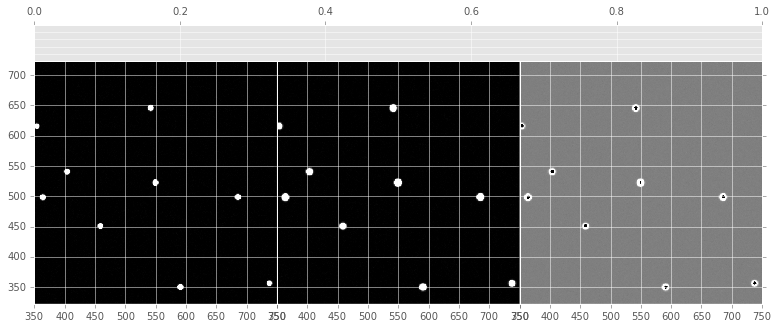

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (15, 5))
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.0, share_all=True, label_mode="L",
                    cbar_location="top", cbar_mode="single")
extent = (xcen-200+imsize/2, xcen+200+imsize/2, ycen-200+imsize/2, ycen+200+imsize/2)
gim = igrid[0].imshow(im1[extent[0]:extent[1],extent[2]:extent[3]], clim=(0,20), origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(im2[extent[0]:extent[1],extent[2]:extent[3]], clim=(0,20), origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2-im1)[extent[0]:extent[1],extent[2]:extent[3]], clim=(-20,20), origin='lower', interpolation='none', cmap='gray', extent=extent)
#igrid.cbar_axes[0].colorbar(gim)

## Let's try running A&L on the two images!

First let's pre-convolve `im2` (science image) with its PSF.

In [8]:
from numpy.polynomial.chebyshev import chebval2d

# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 1   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

from scipy.stats import multivariate_normal

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max(ord)+1
    coef0 = np.zeros(coefLen)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    #ga = singleGaussian2d(x, y, xc=m[0], yc=m[1], sigma_x=s[0]/beta, sigma_y=s[1]/beta)
    #ga /= ga.sum()
    ch = chebval2d(x, y, c=np.outer(coef0, coef1))
    return ch * ga

In [9]:
# Set the coordinates for the bases
xbas = np.arange(-15, 16, 1)
ybas = xbas.copy()
y0bas, x0bas = np.meshgrid(xbas, ybas)
gridbas = np.dstack((y0bas, x0bas))

basis = [chebGauss2d(x0bas, y0bas, gridbas, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=True) for i0,sig0 in enumerate(sigGauss) for i1,sig1 in enumerate(sigGauss) for deg0 in range(degGauss[i0]+1) for deg1 in range(degGauss[i1]+1)]
print len(basis), basis[0].shape, x0bas.shape, basis[0].reshape(x0bas.shape).shape

[0.75, 0.75] [0, 0] [ 1.] [ 1.]
[0.75, 0.75] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[0.75, 0.75] [0, 3] [ 1.  0.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [0, 4] [ 1.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 0.75] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[0.75, 0.75] [1, 3] [ 0.  1.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [1, 4] [ 0.  1.  0.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 0.75] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 0.75] [2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
[0.75, 0.75] [2, 3] [ 0.  0.  1.  0.] [ 0.  0.  0.  1.]
[0.75, 0.75] [2, 4] [ 0.  0.  1.  0.  0.] [ 0.  0.  0.  0.  1.]
[0.75, 0.75] [3, 0] [ 0.  0.  0.  1.] [ 1.  0.  0.  0.]
[0.75, 0.75] [3, 1] [ 0.  0.  0.  1.] [ 0.  1.  0.  0.]
[0.75, 0.75] [3, 2] [ 0.  0.  0.  1.] [ 0.  0.  1.  0.]
[0.75, 0.75] [3, 3] [ 0.  0.  0.  1.] [ 0.  0.  0.  1.]
[0.75, 0.75] [3, 4] [ 0.

In [10]:
print len(basis), basis[0].shape, basis[0].reshape(x0bas.shape).shape, 31*31
basis2 = np.dstack(basis).T  # put the bases into an array
print basis2.shape, basis2[0].shape, basis2[0].reshape(x0bas.shape).shape
print basis[0].min(), basis[0].max(), basis2.min(), basis2.max()

121 (31, 31) (31, 31) 961
(121, 31, 31) (31, 31) (31, 31)
1.0924820179e-131 0.212206590789 -14.1624248714 14.1624248714


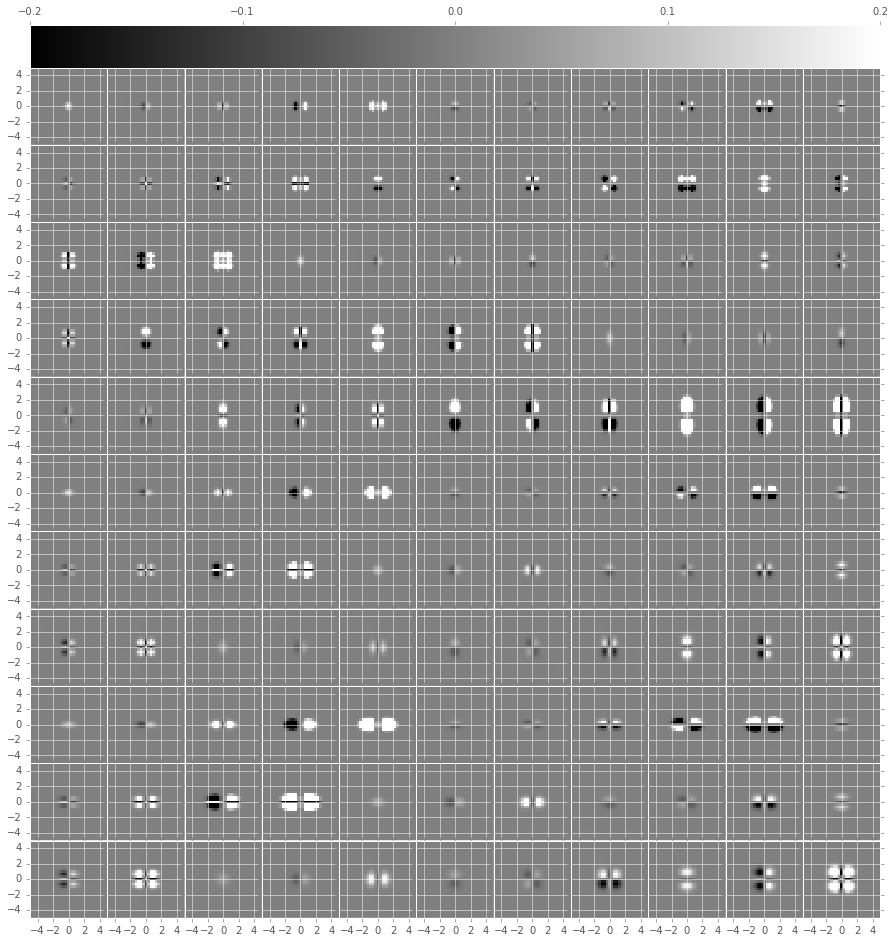

In [11]:
limits = (-0.2, 0.2) #(basis2.min(), basis2.max())
fig = plt.figure(1, (16., 16.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(11, 11),  # creates 2x2 grid of axes
                    axes_pad=0.0, share_all=True, label_mode="L", cbar_location="top", cbar_mode="single")
extent = (x0bas.min()+10, x0bas.max()-10, y0bas.min()+10, y0bas.max()-10)
for i in range(121):
    gim = igrid[i].imshow(basis[i].reshape(x0bas.shape), origin='lower', interpolation='none', cmap='gray', 
                          extent=extent, clim=limits)
igrid.cbar_axes[0].colorbar(gim)

In [11]:
if False:
    im2_psf = gaussian(x, s=psf2)
    im2_psf /= im2_psf.sum()
    im2_preconv = np.convolve(im2, im2_psf, mode='same')
    print im2.sum(), im2_preconv.sum()
    plt.plot(xim, im1); plt.plot(xim, im2); plt.plot(xim, im2_preconv); plt.plot(xim, im2-im1)

## Don't pre-convolve?
im2_preconv = im2

In [14]:
import scipy.ndimage.filters
import scipy.signal

print im2.shape, basis[3].shape
tmp1 = scipy.ndimage.filters.convolve(im1, basis[3], mode='constant')
tmp2 = scipy.signal.fftconvolve(im1, basis[3], mode='same')
print tmp1.shape, tmp1.min(), tmp1.max()
print tmp2.shape, tmp2.min(), tmp2.max()
print (tmp1-tmp2).std(), (tmp1-tmp2).mean()

 (1023, 1023) (31, 31)
(1023, 1023) -1656.26888924 1662.66672718
(1023, 1023) -1656.26888924 1662.66672718
1.02228401392e-13 -1.25822205708e-17


In [15]:
# Single call to do it with all bases
# First use the original (non spatially modified) basis
def tmpfun(im, b, i):
    #print i
    #out = scipy.ndimage.filters.convolve(im, b, mode='constant')
    out = scipy.signal.fftconvolve(im, b, mode='same')
    return out

basis2 = [tmpfun(im1, b, i) for i,b in enumerate(basis)]
print len(basis2), basis2[0].shape

basis2a = np.vstack([b.flatten() for b in basis2]).T
print basis2a.shape, im2.flatten().shape

121 (1023, 1023)
(1046529, 121) (1046529,)


## Do the linear fit.

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3, although it gives identical results, so it was not really wrong. The latter, however, seems to be slightly faster and probably uses less memory.

In [16]:
#%timeit np.linalg.lstsq(basis2, im2_preconv)
pars_old, resid, _, _ = np.linalg.lstsq(basis2a, im2_preconv.flatten())
print pars_old[:8]

fit_old = (pars_old * basis2a).sum(1).reshape(im2_preconv.shape)
print resid, np.sum((im2_preconv - fit_old.reshape(im2_preconv.shape))**2)
print scipy.stats.describe((im2_preconv - im1)**2, axis=None)
print scipy.stats.describe((im2_preconv - fit_old)**2, axis=None)
print basis2a.shape, fit_old.shape

[ -2.02650114e+03   9.35689812e+02  -4.45656782e+03  -2.99785152e-03
  -8.11798685e-01   2.68202253e+03   1.76787393e+01   2.65438511e+02]
[ 2466352.74214822] 2466352.74215
DescribeResult(nobs=1046529, minmax=(2.6901641980476887e-15, 696653.35492402292), mean=64.541186290195739, variance=13077720.141693907, skewness=101.32931730434393, kurtosis=12681.103657894146)
DescribeResult(nobs=1046529, minmax=(1.1871887480695179e-14, 149869.1288035188), mean=2.3566979435336459, variance=169538.14238774288, skewness=247.41933361123074, kurtosis=68887.75425203165)
(1046529, 121) (1023, 1023)


(121,) (961, 121)
1.01933331228


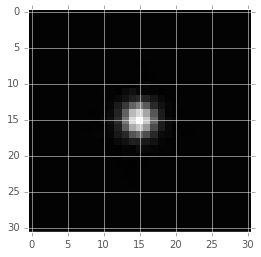

In [17]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars_old.shape, kbasis.shape
kfit = (pars_old * kbasis).sum(1).reshape(basis[0].shape)
print kfit.sum()
kfit /= kfit.sum()
#extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(kfit, interpolation='none', cmap='gray')  # this plots the matching kernel

In [18]:
b = (basis2a.T * im2_preconv.flatten()).sum(1)
print b.shape

M = np.dot(basis2a.T, basis2a)
print M.shape

pars2, resid, _, _ = np.linalg.lstsq(M, b)
print pars2[:8]

(121,)
(121, 121)
[  3.80415756e+01   1.16260996e+00   2.15673806e+00  -1.25252812e-02
   9.80008272e-02   3.85695739e-01   3.89905184e+01  -1.81905612e+00]


(1046529, 121) (1023, 1023) -0.424314959692 970.545794073
DescribeResult(nobs=1046529, minmax=(2.6901641980476887e-15, 696653.35492402292), mean=64.541186290195739, variance=13077720.141693907, skewness=101.32931730434393, kurtosis=12681.103657894146)
DescribeResult(nobs=1046529, minmax=(1.8486769430236127e-13, 149854.359289605), mean=2.3567066471750646, variance=169535.91505585329, skewness=247.4121158018699, kurtosis=68882.24658049559)


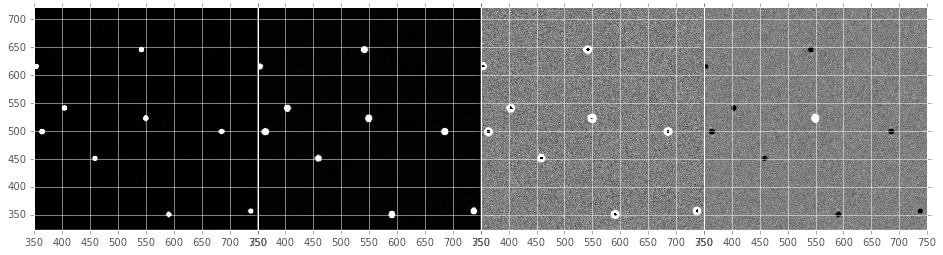

In [19]:
fit2 = (pars2 * basis2a).sum(1).reshape(im2_preconv.shape)
print basis2a.shape, fit2.shape, fit2.min(), fit2.max()
print scipy.stats.describe((im2_preconv - im1)**2, axis=None)
print scipy.stats.describe((im2_preconv - fit2)**2, axis=None)

fig = plt.figure(1, (16, 4))
extent = (xcen-20+imsize/2, xcen+20+imsize/2, ycen-20+imsize/2, ycen+20+imsize/2)
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (xcen-200+imsize/2, xcen+200+imsize/2, ycen-200+imsize/2, ycen+200+imsize/2)
gim = igrid[0].imshow(im1[extent[0]:extent[1],extent[2]:extent[3]], clim=(0,20), origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(fit2[extent[0]:extent[1],extent[2]:extent[3]], clim=(-0.2,20), origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2_preconv-im1)[extent[0]:extent[1],extent[2]:extent[3]], clim=(-2,2), origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2_preconv-fit2)[extent[0]:extent[1],extent[2]:extent[3]], clim=(-2,2), origin='lower', interpolation='none', cmap='gray', extent=extent)

(121,) (961, 121)
1.01939260799


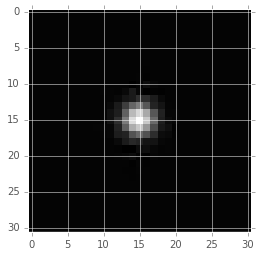

In [20]:
kbasis = np.vstack([b.flatten() for b in basis]).T
print pars2.shape, kbasis.shape
kfit2 = (pars2 * kbasis).sum(1).reshape(basis[0].shape)
print kfit2.sum()
kfit2 /= kfit2.sum()
#extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
plt.imshow(kfit2, interpolation='none', cmap='gray')  # this plots the matching kernel

(1023, 1023) -0.416242923842 952.082432684
DescribeResult(nobs=1046529, minmax=(2.6901641980476887e-15, 696653.35492402292), mean=64.541186290195739, variance=13077720.141693907, skewness=101.32931730434393, kurtosis=12681.103657894146)
DescribeResult(nobs=1046529, minmax=(1.7043575197235643e-13, 162224.75031423863), mean=2.4450424403484647, variance=198701.74056910764, skewness=247.43285130523287, kurtosis=68888.56580451422)


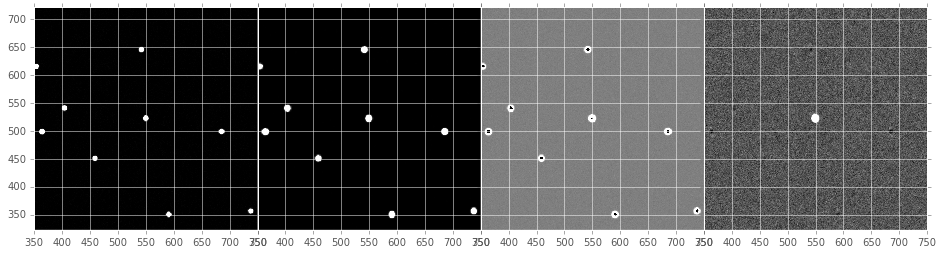

In [24]:
conv_im1 = scipy.ndimage.filters.convolve(im1, kfit2, mode='constant')
print conv_im1.shape, conv_im1.min(), conv_im1.max()
print scipy.stats.describe((im2_preconv - im1)**2, axis=None)
print scipy.stats.describe((im2_preconv - conv_im1)**2, axis=None)

fig = plt.figure(1, (16, 4))
extent = (xcen-20+imsize/2, xcen+20+imsize/2, ycen-20+imsize/2, ycen+20+imsize/2)
igrid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.0)
extent = (xcen-200+imsize/2, xcen+200+imsize/2, ycen-200+imsize/2, ycen+200+imsize/2)
gim = igrid[0].imshow(im1[extent[0]:extent[1],extent[2]:extent[3]], clim=(0,20), origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[1].imshow(conv_im1[extent[0]:extent[1],extent[2]:extent[3]], clim=(0,20), origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[2].imshow((im2_preconv-im1)[extent[0]:extent[1],extent[2]:extent[3]], clim=(-10,10), origin='lower', interpolation='none', cmap='gray', extent=extent)
igrid[3].imshow((im2_preconv-conv_im1)[extent[0]:extent[1],extent[2]:extent[3]], clim=(-1,2), origin='lower', interpolation='none', cmap='gray', extent=extent)

## Compute the "L(ZOGY)" post-conv. kernel from kfit

1.34376289088
-0.0819051709011
1.0


(-0.081905170901122551, 0.081905170901122551)

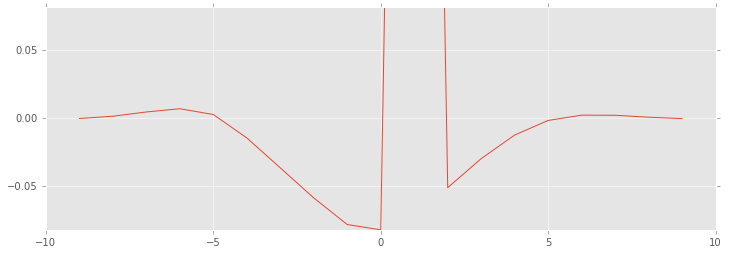

In [19]:
def kernel_ft(kernel):
    kp = kernel
    FFT = fft(kp)
    return FFT
def post_conv_kernel_ft(kernel, sig1=1., sig2=1.):
    kft = kernel_ft(kernel)
    return np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
def post_conv_kernel(kernel, sig1=1., sig2=1.):
    kft = post_conv_kernel_ft(kernel, sig1, sig2)
    out = ifft(kft)
    return out

pck = post_conv_kernel(kfit, sig1=sig2, sig2=sig1)
print pck.real.max()
print pck.real.min()
print pck.real.sum()
plt.plot(x, np.fft.ifftshift(pck.real))
plt.ylim(np.min(pck.real), np.abs(np.min(pck.real))) #; plt.xlim(-2, 2)

## Now convolve the image difference with the kernel.

1.0 1.34376289088 -0.0819051709011


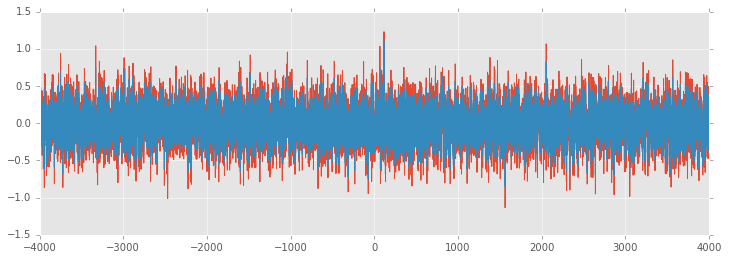

In [20]:
pck = np.fft.ifftshift(pck.real)
print pck.sum(), pck.max(), pck.min()
#pck /= pck.sum()
pci = np.convolve(im2_preconv-conv_im1, pck, mode='same')
plt.plot(xim, pci)  # red - corrected diffim
plt.plot(xim, im2_preconv-conv_im1)  # blue - original diffim

Corrected: -0.00607222856051 0.291531164064
Original:  -0.00606405409772 0.221102805097
Expected:  0.282842712475


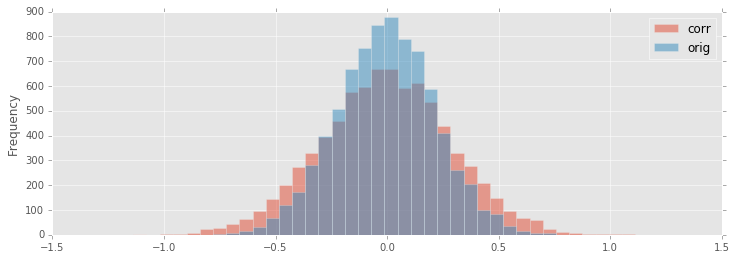

In [21]:
import pandas as pd
df = pd.DataFrame({'corr': pci, 'orig': im2_preconv-conv_im1})
df.plot.hist(alpha=0.5, bins=40)
print 'Corrected:', np.mean(pci), np.std(pci)
print 'Original: ', np.mean(im2_preconv-conv_im1), np.std(im2_preconv-conv_im1)
print 'Expected: ', np.sqrt(sig1**2 + sig2**2)

## Compute the (corrected) diffim's new PSF

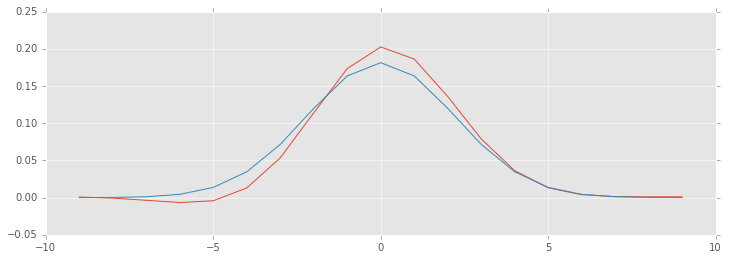

In [22]:
# post_conv_psf = phi_1(k) * sym.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kappa_ft(k)**2))
# we'll parameterize phi_1(k) as a gaussian with sigma "psfsig1".
def post_conv_psf_ft(x, kernel, sig1=1., sig2=1., psfsig1=1.):
    kft = kernel_ft(kernel)
    sig1ft = gaussian_ft(x, s=psfsig1)
    out = sig1ft * np.sqrt((sig1**2 + sig2**2) / (sig1**2 + sig2**2 * kft**2))
    return out
def post_conv_psf(x, kernel, sig1=1., sig2=1., psfsig1=1.):
    kft = post_conv_psf_ft(x, kernel, sig1, sig2, psfsig1)
    out = ifft(kft)
    return out

pcf = post_conv_psf(x, kernel=kfit, sig1=sig2, sig2=sig1, psfsig1=psf2)  # psfsig is sigma of psf of im2 (science image)
pcf = pcf.real / pcf.real.sum()
plt.plot(x, pcf)  # red - corrected PSF
phi2 = gaussian(x, s=psf2) * (x[1]-x[0]) ## compare to phi_1(x)
plt.plot(x, phi2)  # blue - original PSF

Look at how detection would compare in the new diffim vs. the original one by convolving them with their psfs.

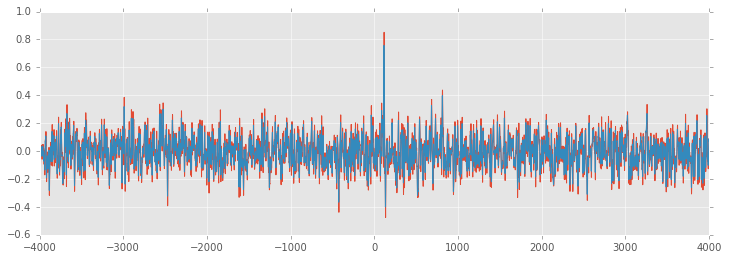

In [23]:
tmp1 = np.convolve(pci, pcf, mode='same')
plt.plot(xim, tmp1)  # red - corrected
tmp2 = np.convolve(im2_preconv-conv_im1, phi2, mode='same')
plt.plot(xim, tmp2)  # blue - original

Detect 5-$\sigma$ sources. First compute stats on the convolved diffim's.

0.566571637971 0.491946696957
6 6
0.554179754856 0.479319468578
1: 6
114.0 119.0
2: 6
112.0 117.0


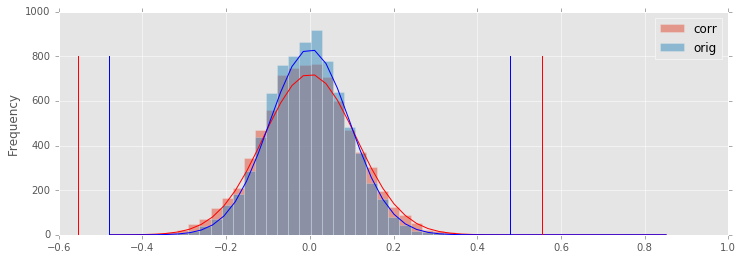

In [24]:
df = pd.DataFrame({'corr': tmp1, 'orig': tmp2})
df.plot.hist(alpha=0.5, bins=50)

print tmp1.std()*5., tmp2.std()*5.
print np.sum(np.abs(tmp1) > tmp1.std()*5.), np.sum(np.abs(tmp2) > tmp2.std()*5.)

import scipy.stats
tmp1a, low, upp = scipy.stats.sigmaclip(tmp1)
tmp2a, low, upp = scipy.stats.sigmaclip(tmp2)
print tmp1a.std()*5., tmp2a.std()*5.

det1 = xim[np.abs(tmp1) > tmp1a.std()*5.]
det2 = xim[np.abs(tmp2) > tmp2a.std()*5.]
print '1:', len(det1)
if len(det1) > 0: 
    print det1.min(), det1.max()
print '2:', len(det2)
if len(det2) > 0:
    print det2.min(), det2.max()

xaxs = np.linspace(df.min()[0], df.max()[0])
plt.plot(xaxs, 200*gaussian(xaxs, s=tmp1a.std()), color='r')
plt.plot(xaxs, 200*gaussian(xaxs, s=tmp2a.std()), color='b')
plt.plot(np.repeat(tmp1a.std()*5., 2), [-0, 800], color='r')
plt.plot(np.repeat(-tmp1a.std()*5., 2), [-0, 800], color='r')
plt.plot(np.repeat(tmp2a.std()*5., 2), [-0, 800], color='b')
plt.plot(np.repeat(-tmp2a.std()*5., 2), [-0, 800], color='b')

(-85, 315)

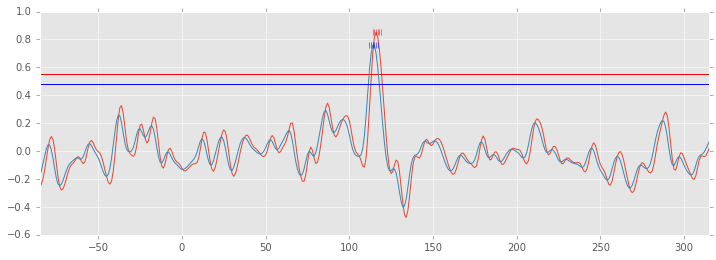

In [25]:
plt.plot(xim, tmp1)  # red - corrected
plt.plot(det1, np.repeat(tmp1.max(), len(det1)), '|', color='r')
plt.plot([xim.min(), xim.max()], np.repeat(tmp1a.std()*5., 2), color='r')
plt.plot(xim, tmp2)  # blue - original
plt.plot(det2, np.repeat(tmp2.max(), len(det2)), '|', color='b')
plt.plot([xim.min(), xim.max()], np.repeat(tmp2a.std()*5., 2), color='b')
plt.xlim(xcen-200, xcen+200)